## Pytorch supervised learning of perceptual decision making task

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neurogym/neurogym/blob/master/examples/example_neurogym_pytorch.ipynb)

Pytorch-based example code for training a RNN on a perceptual decision-making task.

### Installation when used on Google Colab

### Dataset

In [2]:
import numpy as np
import torch
import torch.nn as nn

import neurogym as ngym

# Environment
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)
env = dataset.env
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n

In [4]:
dir(env)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_action_space',
 '_disable_render_order_enforcing',
 '_has_reset',
 '_metadata',
 '_np_random',
 '_observation_space',
 '_reward_range',
 'action_space',
 'class_name',
 'close',
 'env',
 'has_reset',
 'metadata',
 'np_random',
 'observation_space',
 'render',
 'render_mode',
 'reset',
 'reward_range',
 'spec',
 'step',
 'unwrapped']

### Network and Training

In [5]:
class Net(nn.Module):
    def __init__(self, num_h):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(ob_size, num_h)
        self.linear = nn.Linear(num_h, act_size)

    def forward(self, x):
        out, hidden = self.lstm(x)
        x = self.linear(out)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net(num_h=64).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

running_loss = 0.0
for i in range(1000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)

    loss = criterion(outputs.view(-1, act_size), labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 200 == 199:
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / 200))
        running_loss = 0.0

print('Finished Training')

200 loss: 0.10593
400 loss: 0.03184
600 loss: 0.02032
800 loss: 0.01252
1000 loss: 0.01169
Finished Training


In [ ]:
print(net)

### Analysis

In [6]:
# TODO: Make this into a function in neurogym
perf = 0
num_trial = 200
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    ob = ob[:, np.newaxis, :]  # Add batch axis
    inputs = torch.from_numpy(ob).type(torch.float).to(device)

    action_pred = net(inputs)
    action_pred = action_pred.detach().numpy()
    action_pred = np.argmax(action_pred, axis=-1)
    perf += gt[-1] == action_pred[-1, 0]

perf /= num_trial
print('Average performance in {:d} trials'.format(num_trial))
print(perf)

Average performance in 200 trials
0.885


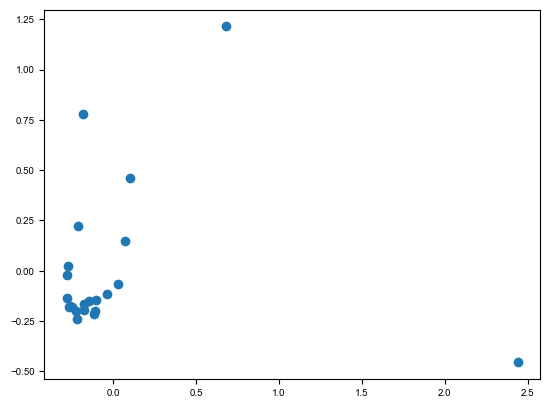

In [17]:
# use PCA to plot the nonlinear dynamics of the hidden state
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

env = dataset.env
env.new_trial()
ob, gt = env.ob, env.gt
ob = ob[:, np.newaxis, :]  # Add batch axis
inputs = torch.from_numpy(ob).type(torch.float).to(device)
hidden = net.lstm(inputs)[0].detach().numpy()
pca = PCA(n_components=2)
pca.fit(hidden[:, -1])  # Remove extra indexing here
hidden_pca = pca.transform(hidden[:, -1])
plt.scatter(hidden_pca[:, 0], hidden_pca[:, 1])
plt.show()

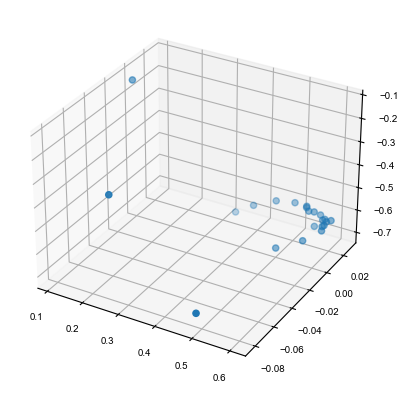

RuntimeError: input must have 3 dimensions, got 2

In [22]:
# use simulation to plot the vector field of the hidden state, and find the fixed point in the hidden state
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

env = dataset.env
env.new_trial()
ob, gt = env.ob, env.gt
ob = ob[:, np.newaxis, :]  # Add batch axis
inputs = torch.from_numpy(ob).type(torch.float).to(device)
hidden = net.lstm(inputs)[0].detach().numpy()
hidden = hidden[:, -1]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hidden[:, 0], hidden[:, 1], hidden[:, 2])
plt.show()






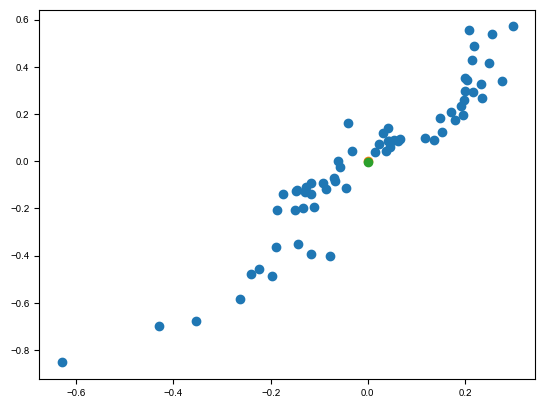

In [19]:
# find the slow point in the hidden state
slow_eig_vec = eig_vec[:, 0]
slow_point = fixed_point + 2 * slow_eig_vec
plt.scatter(hidden[0], hidden[1])
plt.scatter(fixed_point[0], fixed_point[1])
plt.scatter(slow_point[0], slow_point[1])
plt.show()